# 2. The Factors

## Data
Use the data found in `data/factor_pricing_data.xlsx`.

Factors: Monthly excess return data for the overall equity market, $\tilde{r}^{MKT}$.

- The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.

- The sheet also contains data on five additional factors.

- All factor data is already provided as excess returns

In [34]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from utils import *

%config InlineBackend.figure_format = 'retina'

In [6]:
factors = pd.read_excel("../data/factor_pricing_data_monthly.xlsx", sheet_name = "factors (excess returns)", index_col = 0)
portfolio = pd.read_excel("../data/factor_pricing_data_monthly.xlsx", sheet_name = "portfolios (excess returns)", index_col = 0)
annualFactor = 12

### 1.

Analyze the factors, similar to how you analyzed the three Fama-French factors in `Homework 4`.

You now have three additional factors, so let’s compare there univariate statistics.

- mean

- volatility

- Sharpe

In [12]:
print(f"Start from: {min(factors.index)}")
print(f"Start from: {max(factors.index)}")

Start from: 1980-01-31 00:00:00
Start from: 2025-08-31 00:00:00


In [8]:
mean, std, sharpe = Calc_MeanStdSharpe_Stock(factors, annualFactor)
result1 = pd.DataFrame({
    "Mean": mean,
    "Volatility": std,
    "Sharpe": sharpe
}, index = factors.columns)
result1

,Mean,Volatility,Sharpe
MKT,0.087552,0.156142,0.560718
SMB,0.006120,0.101274,0.060435
HML,0.026039,0.108835,0.239249
RMW,0.044047,0.082931,0.531132
CMA,0.028288,0.072480,0.390284
UMD,0.060313,0.153352,0.393299


## 2.
Based on the factor statistics above, answer the following.

- Does each factor have a positive risk premium (positive expected excess return)?
  - Yes, all the factors have a positive risk premium. `MKT` has the highest positive excess return (0.088), while `SMB` has the lowest positive excess return (0.006).

- How have the factors performed since the time of the case, (2015-present)?
  - `MKT` performance improved notably in the 2015-present period compared to the full sample, with both a higher average excess return and a better risk-adjusted return (Sharpe ratio).

  - The other factors showed decline in performance post-2015.

In [13]:
sample_2015 = factors.loc["2015-01-01":]
mean, std, sharpe = Calc_MeanStdSharpe_Stock(sample_2015, annualFactor)
result2 = pd.DataFrame({
    "Mean": mean,
    "Volatility": std,
    "Sharpe": sharpe
}, index = sample_2015.columns)
result2

,Mean,Volatility,Sharpe
MKT,0.117872,0.157356,0.749078
SMB,-0.023775,0.103166,-0.230455
HML,-0.016303,0.129885,-0.125520
RMW,0.040012,0.072632,0.550896
CMA,-0.009141,0.082072,-0.111373
UMD,0.020119,0.137387,0.146438


## 3.
Report the correlation matrix across the six factors.

- Does the construction method succeed in keeping correlations small?

  - No, CMA (Investment) and HML (Value) show high positive correlation (0.68)

- Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?
  
  - Yes, HML (value) has high correlation with CMA (Investment), but has a significant lower returns and sharpe

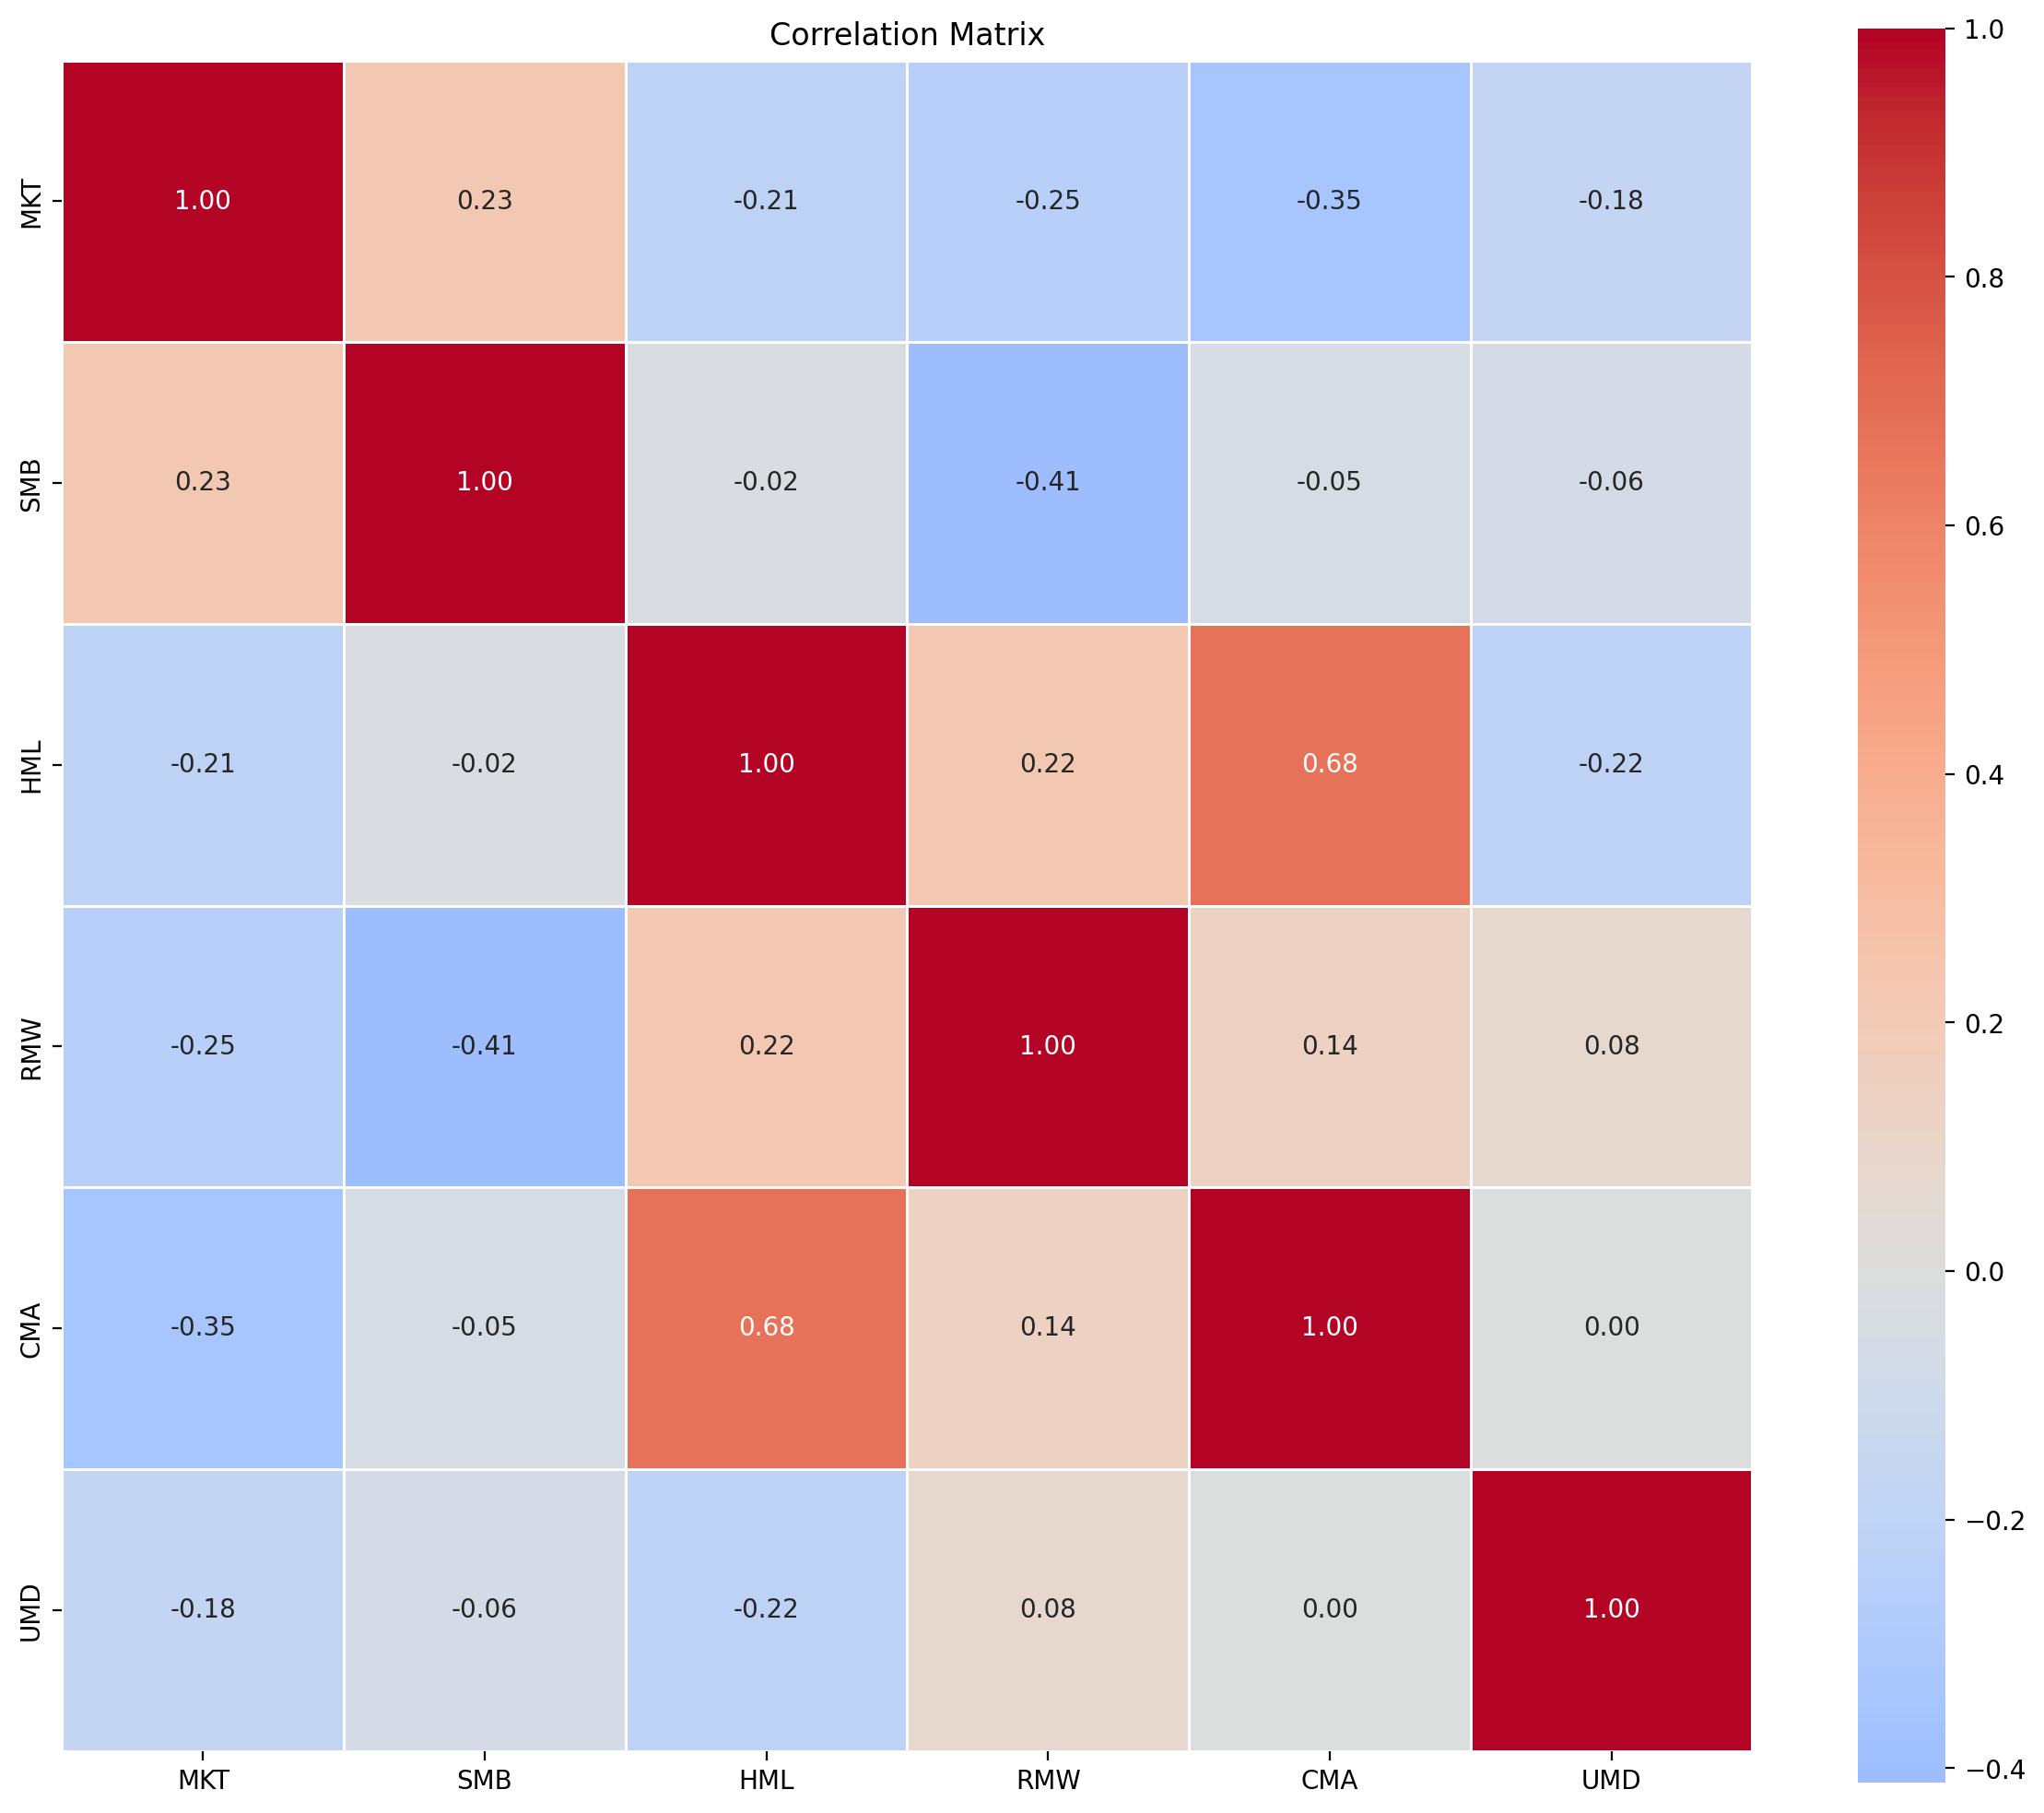

In [16]:
Plot_CorrHeatmap(factors)

### 4.

Report the tangency weights for a portfolio of these 6 factors.

- Which factors seem most important? And Least?
  - `CMA` has the highest weights, while `HML` has negative weights

- Are the factors with low mean returns still useful?

- Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

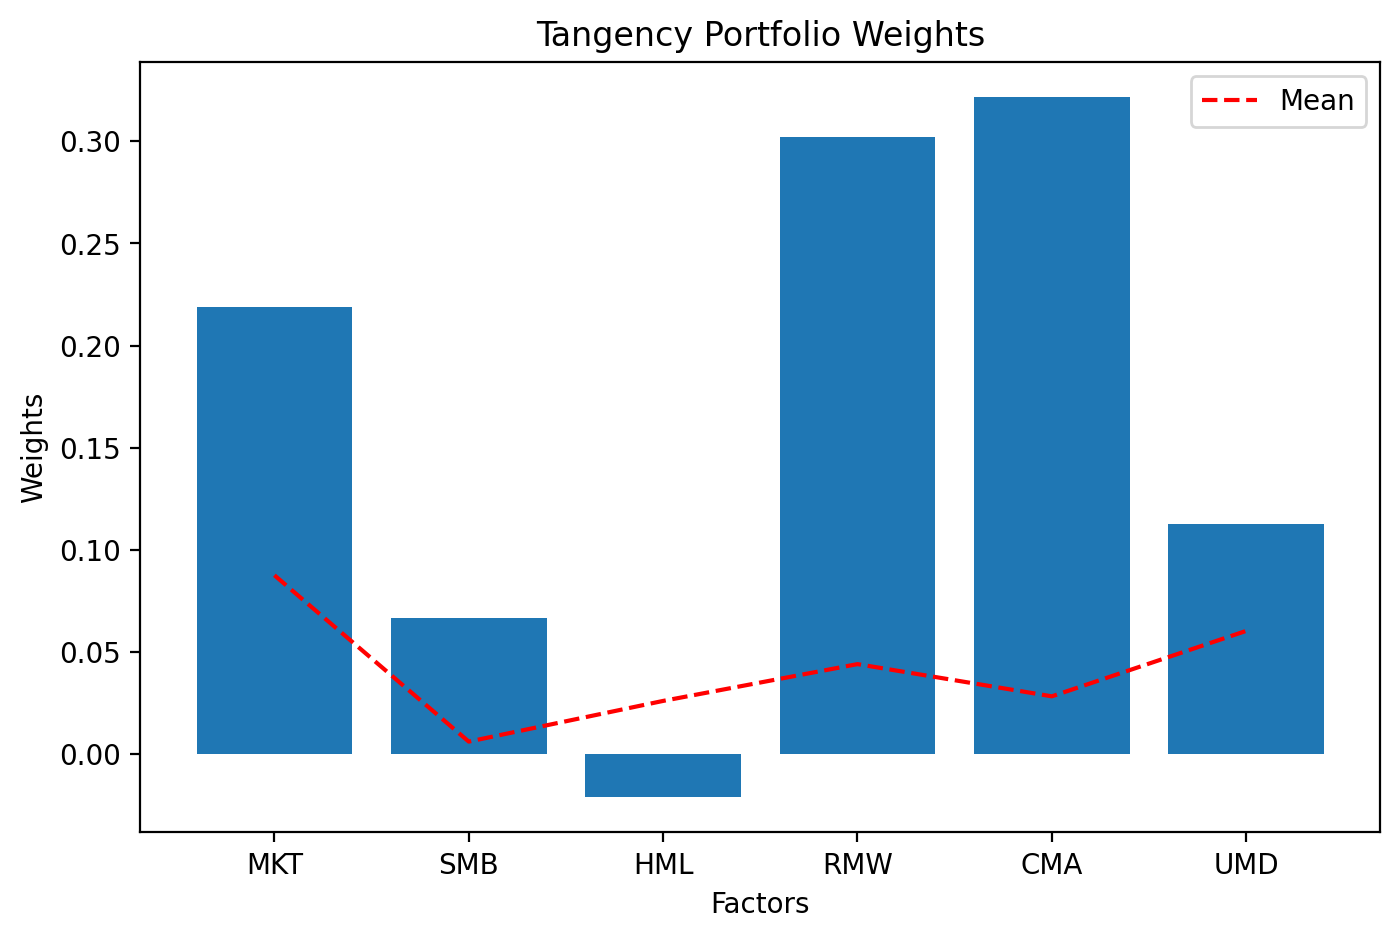

In [27]:
mean, std, sharpe = Calc_MeanStdSharpe_Stock(factors, annualFactor)
weights = Calc_TangencyWeights(factors, annualFactor)
result4 = pd.DataFrame({
    "Weights": weights,
    "Mean": mean
}, index = factors.columns)

plt.figure(figsize = (8, 5))
plt.bar(result4.index, result4["Weights"])
plt.plot(result4.index, result4["Mean"], color = 'red', linestyle='--', label='Mean')
plt.title("Tangency Portfolio Weights")
plt.ylabel("Weights")
plt.xlabel("Factors")
plt.legend()
plt.show()

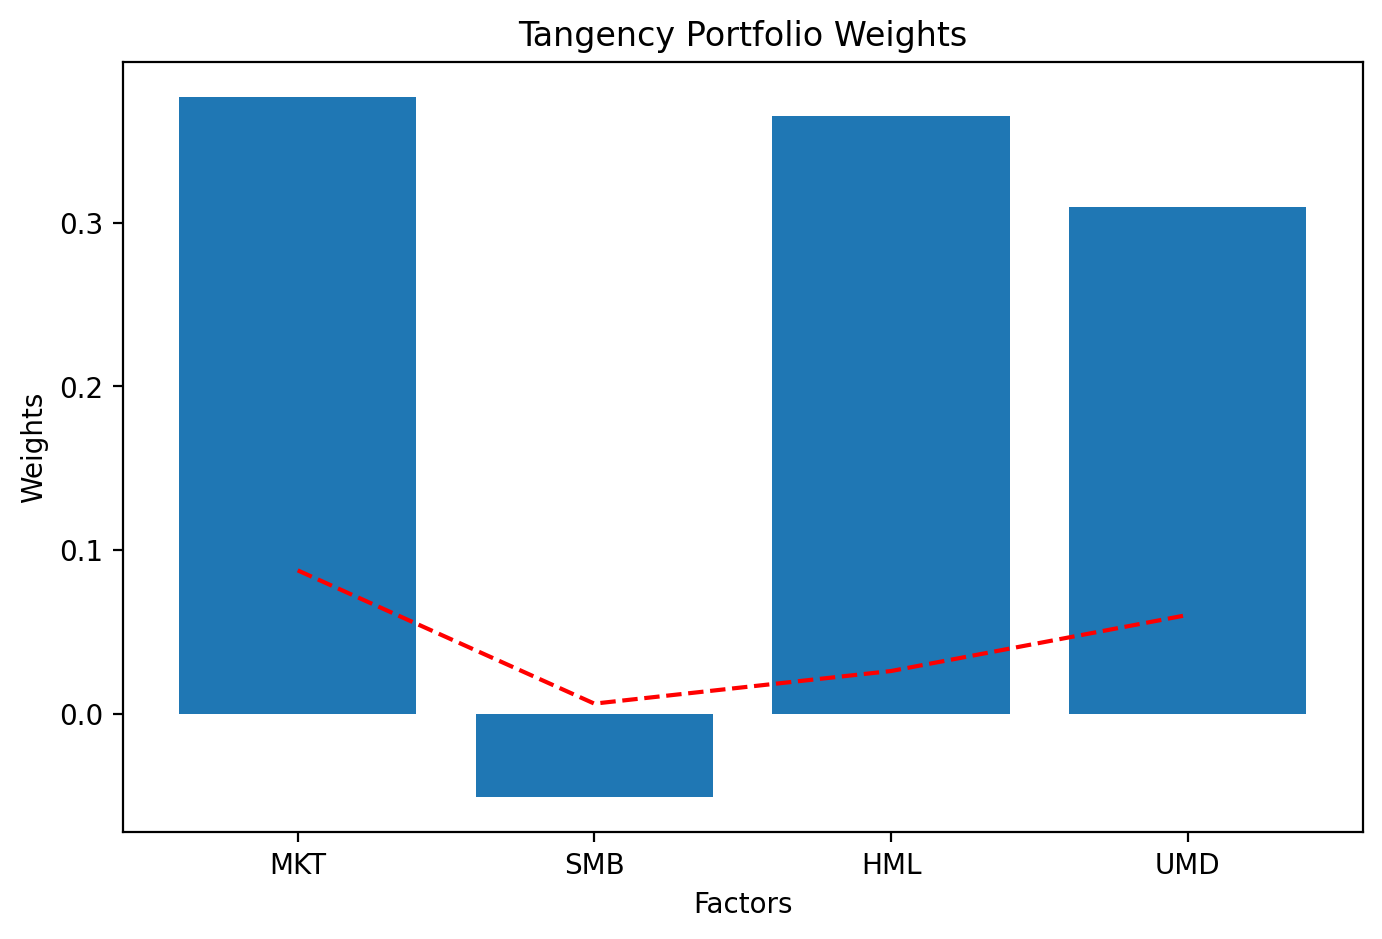

In [28]:
tickers = ['MKT', 'SMB', 'HML', 'UMD']
mean, std, sharpe = Calc_MeanStdSharpe_Stock(factors[tickers], annualFactor)
weights = Calc_TangencyWeights(factors[tickers], annualFactor)
result4 = pd.DataFrame({
    "Weights": weights,
    "Mean": mean
}, index = factors[tickers].columns)

plt.figure(figsize = (8, 5))
plt.bar(result4.index, result4["Weights"])
plt.plot(result4.index, result4["Mean"], color = 'red', linestyle='--', label='Mean')
plt.title("Tangency Portfolio Weights")
plt.ylabel("Weights")
plt.xlabel("Factors")
plt.show()

---

## 3. Testing Modern LPMs

Consider the following factor models:

- **CAPM:** MKT  
- **Fama–French 3F:** MKT, SMB, HML  
- **Fama–French 5F:** MKT, SMB, HML, RMW, CMA  
- **AQR:** MKT, HML, RMW, UMD  

Our labeling of the last model as **AQR** is just for concreteness.  
The firm is well-known for these factors and an unused case study discusses that further.

For instance, for the AQR model:

$$
\mathbb{E}[r^{i}] 
= \beta_{i}^{\mathrm{MKT}}\, \mathbb{E}\!\left[\tilde{f}^{\mathrm{MKT}}\right]
+ \beta_{i}^{\mathrm{HML}}\, \mathbb{E}\!\left[\tilde{f}^{\mathrm{HML}}\right]
+ \beta_{i}^{\mathrm{RMW}}\, \mathbb{E}\!\left[\tilde{f}^{\mathrm{RMW}}\right]
+ \beta_{i}^{\mathrm{UMD}}\, \mathbb{E}\!\left[\tilde{f}^{\mathrm{UMD}}\right].
$$

We will test these models with the time-series regressions.  
Namely, for each asset \( i \), estimate the following regression to test the AQR model:

$$
\tilde{r}_{t}^{\,i}
= \alpha^{i}
+ \beta_{i}^{\mathrm{MKT}} \tilde{f}_{t}^{\mathrm{MKT}}
+ \beta_{i}^{\mathrm{HML}} \tilde{f}_{t}^{\mathrm{HML}}
+ \beta_{i}^{\mathrm{RMW}} \tilde{f}_{t}^{\mathrm{RMW}}
+ \beta_{i}^{\mathrm{UMD}} \tilde{f}_{t}^{\mathrm{UMD}}
+ \varepsilon_{t}.
$$


In [29]:
capm = ['MKT']
ff3f = ['MKT', 'SMB', 'HML']
ff5f = ['MKT', 'SMB', 'HML', 'RMW', 'CMA']
aqr = ['MKT', 'HML', 'RMW', 'UMD']

### Data

- Monthly excess return data on `n=49` equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$, for $n = 1, ...$

- You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

### 1.

Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

For each regression, report the estimated α and r-squared.

In [67]:
def FactorRegression(portfolio, factors, factor_list):
    alpha, beta, rsquared = list(), list(), list()
    for t in portfolio.columns:
        y = portfolio[t]
        x = sm.add_constant(factors[factor_list])
        Betas, _, Information_Ratio, Rsquared, Tracking_Error, Model = Calc_Beta_TreynorRatio_InfoRatio_RSquared_TrackingError(y, x, annualFactor)
        alpha.append(Model.params['const'])
        beta.append(Betas)
        rsquared.append(Rsquared)
    result = pd.DataFrame(beta, columns = factor_list, index = portfolio.columns)
    result.insert(0, 'α', alpha)
    result['R²'] = rsquared
    return result

In [70]:
result_aqr = FactorRegression(portfolio, factors, aqr)
result_aqr

,α,MKT,HML,RMW,UMD,R²
Agric,0.000971,0.838031,0.189249,-0.024173,0.080320,0.342074
Food,0.000125,0.670322,0.186235,0.497298,0.041915,0.455064
Soda,0.001282,0.774898,0.211773,0.503718,-0.084982,0.302544
Beer,0.000821,0.721173,0.046129,0.601211,0.084249,0.414773
Smoke,0.003426,0.731247,0.275801,0.645298,-0.023413,0.265363
Toys,-0.002809,1.108680,-0.004340,0.201011,-0.165362,0.510213
Fun,0.003255,1.233331,-0.051212,-0.128305,-0.249490,0.607213
Books,-0.003059,1.115639,0.262238,0.168885,-0.085422,0.688933
Hshld,-0.001062,0.753724,0.007058,0.494965,0.018731,0.554712
Clths,-0.001889,1.130659,0.033755,0.565797,-0.196702,0.618968


### 2.

Calculate the mean-absolute-error of the estimated alphas.

$$
\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| \tilde{\alpha}^{\,i} \right|
$$
 
- If the pricing model worked, should these alpha estimates be large or small? Why?
  - If the pricing model worked, expected excess returns on each asset $i$ are fully explained by their exposures (betas) to the systematic factors.
   
  - the intercept $\alpha^i$ measures the pricing error, which should be very small since everything is explained by the model.

- Based on your MAE stat, does this seem to support the pricing model or not?
  - The results of the AQR 4-Factor model time-series regressions indicate that the model does not provide sufficient support for the pricing hypothesis. 
    - Mean Absolute Alpha (MAE) = 0.0021 monthly (≈ 2.46% annually), which is about 55% of the average annual portfolio return. This means the average pricing error (α) is large relative to the total expected return — a sign that the model fails to fully capture expected returns across industries.

    - Average R² = 0.5719, suggesting the model explains only about 57% of the time-series variation in returns. While moderate, this level of explanatory power is insufficient to justify the high alpha magnitude.

In [72]:
def MAEReport(result, portfolio, annualFactor):
    mae_monthly = sum(abs(result['α'])) / len(result)
    mae_annual = mae_monthly * annualFactor
    return_monthly = sum(portfolio.mean())
    return_annual = return_monthly * annualFactor

    print(f"Mean Absolute Error of alphas (Monthly): {mae_monthly:.4f}")
    print(f"Mean Absolute Error of alphas (Annualy): {mae_annual:.4f}")
    print(f"Percent of Mean Return: {mae_annual * 100 / return_annual:.4%}")
    print(f"Average R²: {result['R²'].mean():.4f}")
    return mae_monthly, mae_annual

In [ ]:
mae_monthly_aqr, mae_annual_aqr = MAEReport(result_aqr, portfolio, annualFactor)

Mean Absolute Error of alphas (Monthly): 0.0021
Mean Absolute Error of alphas (Annualy): 0.0246
Percent of Mean Return: 55.0539%
Average R²: 0.5719


### 2.

Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.

- Report the MAE statistic for each of these models and compare it with the AQR Model MAE.

- Which model fits best?

**CAPM**

In [76]:
result_capm = FactorRegression(portfolio, factors, capm)
result_capm

,α,MKT,R²
Agric,0.001976,0.799674,0.333250
Food,0.003299,0.569749,0.354061
Soda,0.003767,0.692121,0.244924
Beer,0.004292,0.619614,0.324409
Smoke,0.007164,0.609498,0.182141
Toys,-0.002933,1.111679,0.496254
Fun,0.000920,1.301780,0.586071
Books,-0.001968,1.070199,0.655139
Hshld,0.001377,0.683512,0.486218
Clths,-0.000395,1.085096,0.560742


In [77]:
mae_monthly_capm, mae_annual_capm = MAEReport(result_capm, portfolio, annualFactor)

Mean Absolute Error of alphas (Monthly): 0.0017
Mean Absolute Error of alphas (Annualy): 0.0210
Percent of Mean Return: 46.9101%
Average R²: 0.5226


**Fama-French 3 Factors Model**

In [79]:
result_3f = FactorRegression(portfolio, factors, ff3f)
result_3f

,α,MKT,SMB,HML,R²
Agric,0.001663,0.777755,0.295379,0.148834,0.357284
Food,0.002391,0.637692,-0.222891,0.242387,0.404117
Soda,0.002658,0.762119,-0.165745,0.314615,0.273442
Beer,0.003815,0.673497,-0.266137,0.101431,0.351807
Smoke,0.005774,0.708611,-0.301179,0.377926,0.231158
Toys,-0.002912,1.055475,0.453419,0.072817,0.530488
Fun,0.001005,1.266738,0.255993,0.018265,0.595204
Books,-0.002859,1.085573,0.202247,0.311551,0.691110
Hshld,0.001037,0.722704,-0.196432,0.070877,0.504338
Clths,-0.000871,1.085179,0.174706,0.178060,0.573901


In [80]:
mae_monthly_3f, mae_annual_3f = MAEReport(result_3f, portfolio, annualFactor)

Mean Absolute Error of alphas (Monthly): 0.0020
Mean Absolute Error of alphas (Annualy): 0.0244
Percent of Mean Return: 54.4884%
Average R²: 0.5679


**Fama-French 5 Factors Model**

In [81]:
result_5f = FactorRegression(portfolio, factors, ff5f) 
result_5f

,α,MKT,SMB,HML,RMW,CMA,R²
Agric,0.000597,0.807575,0.344910,0.047503,0.164677,0.185724,0.361897
Food,-0.000535,0.715012,-0.074308,-0.011589,0.490699,0.439389,0.478102
Soda,-0.000141,0.832092,-0.012598,0.092893,0.503126,0.358556,0.306403
Beer,0.000342,0.763306,-0.084372,-0.189579,0.598985,0.491156,0.433565
Smoke,0.001709,0.822935,-0.113602,-0.011562,0.624023,0.716870,0.294362
Toys,-0.005240,1.106866,0.599356,-0.075475,0.475284,0.193325,0.550938
Fun,0.002012,1.228275,0.237307,0.168616,-0.069526,-0.334124,0.599511
Books,-0.004070,1.106188,0.294936,0.266916,0.298596,0.006095,0.702187
Hshld,-0.002043,0.805890,-0.044892,-0.205982,0.501641,0.490123,0.581884
Clths,-0.003749,1.131900,0.401069,0.083981,0.728242,-0.020273,0.629068


In [82]:
mae_monthly_5f, mae_annual_5f = MAEReport(result_5f, portfolio, annualFactor)

Mean Absolute Error of alphas (Monthly): 0.0026
Mean Absolute Error of alphas (Annualy): 0.0314
Percent of Mean Return: 70.1786%
Average R²: 0.5918


In [85]:
result6 = pd.DataFrame({
    "MAE Monthly": [mae_monthly_capm, mae_monthly_3f, mae_monthly_5f, mae_monthly_aqr],
    "MAE Annual": [mae_annual_capm, mae_annual_3f, mae_annual_5f, mae_annual_aqr]
}, index = ['CAPM', 'Fama-French 3 Factors', 'Fama-French 5 Factors', 'AQR 4 Factors'])
result6

,MAE Monthly,MAE Annual
CAPM,0.001748,0.020970
Fama-French 3 Factors,0.002030,0.024358
Fama-French 5 Factors,0.002614,0.031372
AQR 4 Factors,0.002051,0.024611


- CAPM fits best in this dataset, as it produces the lowest mean absolute pricing errors.
The additional factors in the Fama–French and AQR models do not improve pricing accuracy, suggesting that the simple market factor (`MKT`) alone explains returns nearly as well — or even better — than the multi-factor specifications.

### 3.

Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

- `MKT` (Market) is by far the largest across all models, confirms that market exposure dominates return variation

- `UMD` (Momentum) has very small average beta (~0.10) and does not meaningfully reduce pricing errors compared to Fama–French 3 factors model, suggesting it is unimportant for pricing in this dataset.

In [103]:
ALL = ['MKT','SMB','HML','RMW','CMA','UMD']  # desired column order

avg_series = {
    'CAPM'                 : result_capm[['MKT']].abs().mean(),
    'Fama–French 3 Factors': result_3f[ff3f].abs().mean(),
    'Fama–French 5 Factors': result_5f[ff5f].abs().mean(),
    'AQR 4 Factors'        : result_aqr[aqr].abs().mean(),
}

avg_beta_df = pd.DataFrame(avg_series).T.reindex(columns=ALL)
avg_beta_df["MAE"] = [mae_annual_capm, mae_annual_3f, mae_annual_5f, mae_annual_aqr]
avg_beta_df.style.format('{:.4f}', na_rep='')

,MKT,SMB,HML,RMW,CMA,UMD,MAE
CAPM,1.0141,,,,,,0.0210
Fama–French 3 Factors,1.0154,0.2594,0.2997,,,,0.0244
Fama–French 5 Factors,1.0430,0.3039,0.2535,0.3533,0.2398,,0.0314
AQR 4 Factors,1.0442,,0.2633,0.2756,,0.1002,0.0246


### 4.

This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.

- Do this for each of the three models you tested.

- Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?
  - As model complexity rises (more factors), R² increases, meaning the regression explains a higher share of time-series variation in returns.
  
  - However, MAE also rises, meaning the average pricing error (alpha) across portfolios becomes larger and these additional factors do not improve the model’s ability to price assets.

  - Thus, while they may help in a Linear Factor Decomposition (better time-series fit), they do not enhance pricing performance.

In [104]:
result6 = pd.DataFrame({
    "MAE Monthly": [mae_monthly_capm, mae_monthly_3f, mae_monthly_5f, mae_monthly_aqr],
    "MAE Annual": [mae_annual_capm, mae_annual_3f, mae_annual_5f, mae_annual_aqr],
    "R Squared": [result_capm['R²'].mean(), result_3f['R²'].mean(), result_5f['R²'].mean(), result_aqr['R²'].mean()]
}, index = ['CAPM', 'Fama-French 3 Factors', 'Fama-French 5 Factors', 'AQR 4 Factors'])
result6

,MAE Monthly,MAE Annual,R Squared
CAPM,0.001748,0.020970,0.522622
Fama-French 3 Factors,0.002030,0.024358,0.567874
Fama-French 5 Factors,0.002614,0.031372,0.591768
AQR 4 Factors,0.002051,0.024611,0.571935


### 5.

We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

**Time-Series Regression:**

$$
\tilde{r}_i = \alpha^i + \beta^i f_t + \epsilon^i_t
$$

- $\alpha^i$: Mispricing over time for asset $i$. If model is correct, $\alpha^i = 0$
- $\epsilon^i_t$: The unexplained shock in period in period $t$ for asset $i$. Represents noise, idiosyncratic risk, or short-term deviations

$$
\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| \tilde{\alpha}^{\,i} \right|
$$

**Cross-Sectional Regression:**

$$
\tilde{r}_i = \lambda_0 + \lambda_1 \beta^{MKT}_{i} + \lambda_2 \beta^{SMB}_{i} + ... + \eta_i
$$

- $\lambda_0$: Systematic pricing bias across all assets. If model prices assets correctly, $\lambda_0 = 0$

- $\eta_i$: Pricing error for asset $i$

$$
\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} |\eta_i|
$$


- Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

- Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

**CAPM**

In [148]:
mean_portfolio, _, _ = Calc_MeanStdSharpe_Stock(portfolio, annualFactor)

def CrossSectionalRegression(mean_portfolio, factor_returns):
    y = mean_portfolio
    x = sm.add_constant(factor_returns)
    model = sm.OLS(y, x).fit()
    print(f"R Squared: {model.rsquared:.4f}")
    print(f"Intercept: {model.params['const']:.4f}")
    print(f"Coefficients:")
    print(model.params.drop("const"))
    mae = sum(abs(model.resid)) / len(model.resid)
    print(f"\nMAE of the cross-sectional regression residuals: {mae:.4f}")
    return model, mae

In [150]:
model_capm, mae_capm = CrossSectionalRegression(mean_portfolio, result_capm[capm])

R Squared: 0.0093
Intercept: 0.0832
Coefficients:
MKT    0.00792
dtype: float64

MAE of the cross-sectional regression residuals: 0.0152


**Fama-French 3 Factors**

In [151]:
model_3f, mae_3f = CrossSectionalRegression(mean_portfolio, result_3f[ff3f])

R Squared: 0.3504
Intercept: 0.0627
Coefficients:
MKT    0.038844
SMB   -0.039625
HML   -0.021037
dtype: float64

MAE of the cross-sectional regression residuals: 0.0120


**Fama-French 5 Factors**

In [152]:
model_5f, mae_5f = CrossSectionalRegression(mean_portfolio, result_5f[ff5f])

R Squared: 0.3765
Intercept: 0.0599
Coefficients:
MKT    0.040320
SMB   -0.041428
HML   -0.025943
RMW    0.018705
CMA   -0.022083
dtype: float64

MAE of the cross-sectional regression residuals: 0.0120


**AQR**

In [153]:
model_aqr, mae_aqr = CrossSectionalRegression(mean_portfolio, result_aqr[aqr])

R Squared: 0.2066
Intercept: 0.0755
Coefficients:
MKT    0.017193
HML   -0.032258
RMW    0.017549
UMD    0.000286
dtype: float64

MAE of the cross-sectional regression residuals: 0.0136


In [154]:
mae_result = pd.DataFrame({
    "MAE Cross-Sectional Regression": [mae_capm, mae_3f, mae_5f, mae_aqr]
}, index = ['CAPM', 'Fama-French 3 Factors', 'Fama-French 5 Factors', 'AQR 4 Factors'])
mae_result

,MAE Cross-Sectional Regression
CAPM,0.015204
Fama-French 3 Factors,0.012002
Fama-French 5 Factors,0.011979
AQR 4 Factors,0.013608
